In [2]:
from pathlib import Path
from pathlib import *
import pandas as pd
import re
from random import randint
from random import shuffle
import spacy
from time import time
import matplotlib.pyplot as plt
import gensim.corpora as corpora
import gensim
from pprint import pprint
from gensim.models import TfidfModel
from gensim.models import CoherenceModel
from gensim import  models
from gensim.test.utils import datapath
nlpd = spacy.load("da_core_news_lg")

# 80'erne simpel topic model
Det følgende script vil søge at lave en topic-model over den danske EU-debat, men hvor domænespecifikke begreber ikke undlades, ligesom at der ikke lades TD-IDF på data.

In [3]:
path = "../../Folketingstidende/Hele/"
dir_path = Path(f"{path}")
csv_files = list(dir_path.glob("*.csv"))

In [4]:
csv_files.sort() #sorter så data kommer i rigtig rækkefølge
csv_files[0:5]

[PosixPath('../../Folketingstidende/Hele/19531.csv'),
 PosixPath('../../Folketingstidende/Hele/19541.csv'),
 PosixPath('../../Folketingstidende/Hele/19551.csv'),
 PosixPath('../../Folketingstidende/Hele/19561.csv'),
 PosixPath('../../Folketingstidende/Hele/19562.csv')]

In [5]:
csv_files[35:49]

[PosixPath('../../Folketingstidende/Hele/19801.csv'),
 PosixPath('../../Folketingstidende/Hele/19811.csv'),
 PosixPath('../../Folketingstidende/Hele/19812.csv'),
 PosixPath('../../Folketingstidende/Hele/19821.csv'),
 PosixPath('../../Folketingstidende/Hele/19831.csv'),
 PosixPath('../../Folketingstidende/Hele/19832.csv'),
 PosixPath('../../Folketingstidende/Hele/19841.csv'),
 PosixPath('../../Folketingstidende/Hele/19851.csv'),
 PosixPath('../../Folketingstidende/Hele/19861.csv'),
 PosixPath('../../Folketingstidende/Hele/19862.csv'),
 PosixPath('../../Folketingstidende/Hele/19871.csv'),
 PosixPath('../../Folketingstidende/Hele/19872.csv'),
 PosixPath('../../Folketingstidende/Hele/19881.csv'),
 PosixPath('../../Folketingstidende/Hele/19891.csv')]

In [6]:
Folketingstaler_i_80erne = {}
for fil in csv_files[35:49]:
    if str(fil)[-9:-5] in Folketingstaler_i_80erne:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        for tale in taler:
            Folketingstaler_i_80erne[str(fil)[-9:-5]].append(tale)
    else:
        folketingsår = pd.read_csv(fil ,sep=';', encoding = "latin1")
        taler = folketingsår["indhold"]
        Folketingstaler_i_80erne[str(fil)[-9:-5]] = []
        for tale in taler:
            Folketingstaler_i_80erne[str(fil)[-9:-5]].append(tale)

In [7]:
def FT_taler(indhold):
    talere = []
    tale = []
    parti = []
    Partier_i_folketinget = ["(A)", "(SF)", "(S)", "(RV)", "(KF)", "(V)", "(FP)", "(CD)", "(VS)",
                             "(KrF)", "(DR)", "(UP)", "(Grønl.)", "(Fær.)"]
    for index in range(len(indhold)):
        sentence = indhold[index]
        if len(re.findall("(^.{1,50} \([A-Z]+\)|^.{1,50} \(KrF\)|^.{1,50} \(Grønl.\)|^.{1,50} \(Fær.\))", sentence)) > 0: #Tjekker om det er et menigt medlem
            if len(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)) < 2:
                if len(re.findall("Ny stedf.", sentence)) > 0:
                    pass
                elif len(re.findall("Udtræder:", sentence)) > 0:
                    pass
                elif len(re.findall("Nyt medl", sentence)) > 0:
                    pass
                elif len(re.findall(" af", sentence.lower())) > 0:
                    pass
                elif re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0] in Partier_i_folketinget:
                    talere.append(sentence)
                    parti.append(re.findall("(\([A-Z]+\)|\(KrF\)|\(Grønl.\)|\(Fær.\))", sentence)[0])
                    tale.append("")
                else:
                    if len(tale) >= 1:
                        tale[-1] = tale[-1] + " " + sentence
            else: #ellers er det en tale
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
                #if len(re.findall("(\([A-Z]+\)|\(KrF\))", sentence)) < 2:
        elif sentence.lower() == "formanden" or sentence.lower() == "formanden:": #tjekker om det er formanden der taler
            talere.append("formanden")
            parti.append("Formanden")
            tale.append("")
        elif re.search("næstformand \(\w*\):$", sentence.lower()) or re.search("næstformand \(\w* \w*\):$", sentence.lower()):
            talere.append(sentence.lower())
            parti.append("næstformanden")
            tale.append("")
        elif len(sentence) < 100: #Tjekker om det er en minister der taler
            if len(re.findall("\w*minister[\w ]*\(([\w-]*|[\w ]*)\)", sentence.lower())) > 0:
                talere.append(sentence)
                parti.append("Regeringen")
                tale.append("")
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("[1-9]{1,5} [1-9]{1,2}/[1-9]{1,2}", sentence.lower()))  > 0: #tilføjet til at fange headers på sider
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif len(re.findall("^[1-9]{1,2}/[1-9]{1,2}", sentence.lower())) > 0: 
            if len(sentence) < 170:
                pass
            else:
                if len(tale) >= 1:
                    tale[-1] = tale[-1] + " " + sentence
        elif re.fullmatch("\[.{1,100}\]", sentence.lower()):
            pass
        elif re.fullmatch("[1-9]{1,10}", sentence.lower()):
            pass
        else:
            if len(tale) >= 1:
                tale[-1] = tale[-1] + " " + sentence
    return tale, talere, parti

In [8]:
Folketingsår_opdelt_per_taler_80erne = {}
for år in Folketingstaler_i_80erne:
    indhold = Folketingstaler_i_80erne[år]
    år_tale, år_talere, år_parti = FT_taler(indhold)
    Folketingsår_opdelt_per_taler_80erne[år] = []
    Folketingsår_opdelt_per_taler_80erne[år].append(år_tale)
    Folketingsår_opdelt_per_taler_80erne[år].append(år_talere)
    Folketingsår_opdelt_per_taler_80erne[år].append(år_parti)

In [9]:
EU_ord = [" eu ", " ef ", "europæiske fællesskab", "europæiske union", "fællesmarked", "ømu", " ef-", " eu-",
          "europæiske samarbejde", "fællesakt", " ømu", "det indre marked"]

In [10]:
eu_taler_80erne = {}
for år in Folketingsår_opdelt_per_taler_80erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_80erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_80erne[år][0][index]
        for ord_ in EU_ord:
            if len(re.findall(ord_, tale.lower())) > 0:
                eu_tale_år.append(tale)
                eu_taler_år.append(Folketingsår_opdelt_per_taler_80erne[år][1][index])
                eu_parti_år.append(Folketingsår_opdelt_per_taler_80erne[år][2][index])
                break
    eu_taler_80erne[år] = []
    eu_taler_80erne[år].append(eu_tale_år)
    eu_taler_80erne[år].append(eu_parti_år)
    eu_taler_80erne[år].append(eu_taler_år)
    #slut = time()
    #print(slut-start) til at time loopsne

In [11]:
for år in eu_taler_80erne:
    print(f"{år}: {len(eu_taler_80erne[år][0])}")

1980: 506
1981: 594
1982: 510
1983: 527
1984: 419
1985: 863
1986: 607
1987: 671
1988: 940
1989: 999


In [12]:
antal_taler_år = [len(eu_taler_80erne[i][0]) for i in eu_taler_80erne]

In [13]:
antal_taler_år

[506, 594, 510, 527, 419, 863, 607, 671, 940, 999]

In [14]:
år_1980erne = [str(1980 + i) for i in range(10)]

In [15]:
år_1980erne

['1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989']

In [16]:
Alle_taler = []
Alle_taler_år = []
Alle_taler_parti = []
Alle_taler_taler = []
for år in eu_taler_80erne:
    for index in range(len(eu_taler_80erne[år][0])):
        Alle_taler.append(eu_taler_80erne[år][0][index])
        Alle_taler_parti.append(eu_taler_80erne[år][1][index])
        Alle_taler_taler.append(eu_taler_80erne[år][2][index])
        Alle_taler_år.append(år)

In [17]:
len(Alle_taler)

6636

In [18]:
tekster_klar = []
fyldetegn = [",", ".", "(", ")", "?", "/", "!", ":", " ", "):", "-", "«", "»", "[", "]"]
stopord_fil = open('../../Folketingstidende/stopord.txt','r')
stopord = [word[:-1] for word in stopord_fil]

In [19]:
len(tekster_klar)

0

In [20]:
typer_spacy = []
for tegn in fyldetegn:
    tekst_nlpd = nlpd(tegn)
    for token in tekst_nlpd:
        if token.pos_ not in typer_spacy:
            typer_spacy.append(token.pos_)

In [21]:
typer_spacy

['PUNCT', 'X', 'SPACE', 'ADJ', 'PROPN']

In [22]:
typer_spacy.remove("PROPN")

In [23]:
for år in eu_taler_80erne:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in eu_taler_80erne[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar.append(tokens_uden_tegn)
    end = time()
    print(end-start)

85.87749910354614
85.72350311279297
75.05977416038513
69.97740316390991
67.68477177619934
106.56253004074097
104.38537788391113
116.84166407585144
132.48006796836853
115.81734299659729


In [24]:
processed_data = []
for tekst in tekster_klar:
    str_tekst = [str(token) for token in tekst]
    processed_data.append(str_tekst)

In [25]:
len(processed_data)

6636

In [26]:
bigram = gensim.models.Phrases(processed_data, min_count=5, threshold=100)

trigram = gensim.models.Phrases(bigram[processed_data], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram_mod = gensim.models.phrases.Phraser(trigram)

In [27]:
def remove_stopwords(texts):
    return [[word for word in doc if word not in stopord] for doc in texts]
def create_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def create_trigrams(texts):
    [trigram_mod[bigram_mod[doc]] for doc in texts]
def lemmatize(texts, allowed_postags=[ 'NOUN', 'ADJ', 'VERB', 'PROPN']):
    texts_op = []
    start = time()
    for sent in texts:
        doc = nlpd(" ".join(sent))
        texts_op.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    end = time()
    print(end-start)
    return texts_op

In [28]:
#removing stopwords, creating bigrams and lemmatizing the text

data_wo_stopwords = remove_stopwords(processed_data)

data_bigrams = create_bigrams(data_wo_stopwords)

data_lemmatized = lemmatize(data_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

stopwords_removed_2 = remove_stopwords(data_lemmatized) #Jeg prøver at sortere stopord fra igen

#shuffle(stopwords_removed_2)

data_lemmatized = stopwords_removed_2

291.84009075164795


In [29]:
#gensim_dictionary = corpora.Dictionary(data_lemmatized) #uden shuffle

#texts = data_lemmatized

#gensim_corpus_ikke_random = [gensim_dictionary.doc2bow(text) for text in texts] #uden_shuffle

In [30]:
len(data_lemmatized)

6636

In [280]:
#gensim_dictionary = corpora.Dictionary(data_lemmatized)

texts = [text for text in data_lemmatized]

shuffle(texts)

gensim_dictionary = corpora.Dictionary(texts)

gensim_corpus = [gensim_dictionary.doc2bow(text) for text in texts]

In [ ]:
gensim_dictionary.save("Dictionaries/1980_erne/LDA_1980_21_topics_simple_02_10_22_nummer_4_ikke_afgift_dictionary")

In [53]:
gensim_dictionary = corpora.Dictionary.load("Dictionaries/1980_erne/LDA_1980_23_topics_simple_02_10_22_nummer_2_bedre_dictionary")

In [26]:
#shuffle(gensim_corpus)

In [27]:
gensim_corpus_ikke_random = [gensim_dictionary.doc2bow(text) for text in data_lemmatized]

## Coherence model

In [281]:
def compute_coherence_values(k):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus,
                                           id2word=gensim_dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=gensim_dictionary, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [282]:
# Topics range
min_topics = 17
max_topics = 25
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
model_results = {'Topics': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    print(k)
    # get the coherence score for the given topics
    cv = compute_coherence_values(k=k)
    # Save the model results
    model_results['Topics'].append(k)
    model_results['Coherence'].append(cv)

17
18
19
20
21
22
23
24


Text(0.5, 1.0, 'Simple model')

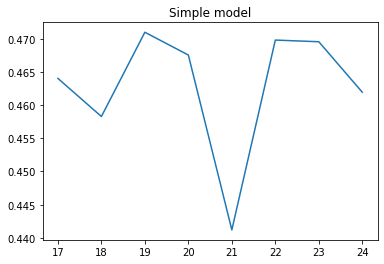

In [283]:
fig, ax = plt.subplots()
ax.plot(model_results["Topics"], model_results['Coherence'])
ax.set_title("Simple model")

In [262]:
model_results['Coherence'].index(max(model_results['Coherence']))

3

In [263]:
max(model_results['Coherence'])

0.5041102124005132

In [40]:
max(model_results['Coherence'])

0.5026590257677488

In [284]:
lda_model = gensim.models.ldamodel.LdaModel(corpus = gensim_corpus,
                                            id2word = gensim_dictionary,
                                            num_topics = 19,
                                            random_state = 100,
                                            update_every = 1,
                                            chunksize = 100,
                                            passes = 10,
                                            alpha = "auto",
                                            )

Jeg gemmer nu denne topic model.

In [40]:
#temp_file = datapath("LDA_1980_22_topics_simple_30_09_22_med_adv_random")
#lda_model.save(temp_file) #den er gemt en enkelt gang

In [41]:
lda_model = models.ldamodel.LdaModel.load(temp_file)

In [202]:
#lda_model.save("Modeller/1980_erne/LDA_1980_21_topics_simple_02_10_22_nummer_2_bedre")

In [150]:
#lda_model = models.ldamodel.LdaModel.load("Modeller/1980_erne/LDA_1980_23_topics_simple_02_10_22_nummer_2_bedre")

In [223]:
lda_model.save("Modeller/1980_erne/LDA_1980_21_topics_simple_02_10_22_nummer_4_ikke_afgift")

In [ ]:
#"LDA_1980_23_topics_simple_30_09_22_med_adv_random"

In [32]:
lda_model = models.ldamodel.LdaModel.load("Modeller/1980_erne/LDA_1980_23_topics_simple_02_10_22_nummer_2_bedre")

In [33]:
pprint(lda_model.show_topics(-1))

[(0,
  '0.038*"redegørelse" + 0.021*"område" + 0.017*"forskning" + 0.017*"mulighed" '
  '+ 0.016*"behov" + 0.016*"støtte" + 0.015*"indsats" + 0.014*"projekt" + '
  '0.013*"yde" + 0.012*"kvinde"'),
 (1,
  '0.069*"udenrigsminister" + 0.047*"sovjetunionen" + 0.030*"sydafrika" + '
  '0.024*"sanktion" + 0.022*"pol" + 0.021*"fn" + 0.019*"støtte" + 0.018*"vest" '
  '+ 0.018*"situation" + 0.018*"usa"'),
 (2,
  '0.020*"regering" + 0.017*"danmark" + 0.015*"spørgsmål" + 0.013*"ef" + '
  '0.012*"give" + 0.012*"folketing" + 0.011*"ønske" + 0.011*"land" + '
  '0.010*"dag" + 0.009*"side"'),
 (3,
  '0.049*"land" + 0.048*"samarbejde" + 0.035*"udvikling" + 0.017*"arbejde" + '
  '0.015*"danmark" + 0.013*"europa" + 0.012*"område" + 0.010*"år" + '
  '0.010*"østeuropa" + 0.010*"initiativ"'),
 (4,
  '0.095*"grønland" + 0.054*"fiskeri" + 0.024*"færøerne" + 0.022*"fisker" + '
  '0.021*"kvote" + 0.020*"fiskeriminister" + 0.019*"bemyndigelse" + 0.017*"ef" '
  '+ 0.017*"grønlands" + 0.016*"tredjeland"'),
 (5,
  '

### Tidligere model uden adverbier og med 17 topics

In [44]:
#indlæsning af topic model lavet tidligere:
#temp_file = datapath("LDA_1980_17_topics_simple_19_09_22")
#lda_model = models.ldamodel.LdaModel.load(temp_file)
#pprint(lda_model.print_topics())

In [ ]:
#indlæsning af model 2 lavet tidligere 2 topics med adverbier
#temp_file = datapath("LDA_1980_20_topics_simple_21_09_22_med_adv")
#lda_model = models.ldamodel.LdaModel.load(temp_file)

In [ ]:
#temp_file = datapath("LDA_1980_21_topics_simple_27_09_22_med_adv")
#lda_model.save(temp_file) #den er gemt en enkelt gang

In [ ]:
#temp_file = datapath("LDA_1980_18_topics_simple_28_09_22_med_adv")
#lda_model.save(temp_file) #den er gemt en enkelt gang

In [ ]:
#temp_file = datapath("LDA_1980_20_topics_simple_29_09_22_med_adv_random")
#lda_model.save(temp_file) #den er gemt en enkelt gang

In [ ]:
#temp_file = datapath("LDA_1980_23_topics_simple_30_09_22_med_adv_random")
#lda_model.save(temp_file) #den er gemt en enkelt gang

In [ ]:
#temp_file = datapath("LDA_1980_23_topics_simple_01_10_22_med_adv_random_1")

## Tildeling af emne til tekster

In [304]:
topics = []
for index in range(len(data_lemmatized)):
    sand_top = 0
    best_topic = 0
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if sand > sand_top:
            sand_top = sand
            best_topic = topic
    topics.append(best_topic)

In [305]:
def count_topics(topics, antal_topics):
    forskellige_topics = [i for i in range(antal_topics)]
    antal_af_hver_topic = [0 for i in range(antal_topics)]
    for topic in topics:
        antal_af_hver_topic[topic] += 1
    return [forskellige_topics, antal_af_hver_topic]

In [306]:
resultat = count_topics(topics, 23)

In [307]:
for topic in resultat[0]:
    print(f"Topic {topic}: {resultat[1][topic]}")

Topic 0: 80
Topic 1: 2
Topic 2: 4904
Topic 3: 179
Topic 4: 9
Topic 5: 703
Topic 6: 9
Topic 7: 5
Topic 8: 0
Topic 9: 1
Topic 10: 17
Topic 11: 181
Topic 12: 4
Topic 13: 0
Topic 14: 29
Topic 15: 1
Topic 16: 0
Topic 17: 1
Topic 18: 3
Topic 19: 200
Topic 20: 307
Topic 21: 0
Topic 22: 1


### Undersøgelse af topic 1: 

In [63]:
topics_1 = []
topics_1_sand = []
for index in range(len(data_lemmatized)):
    sand_top = 0
    best_topic = 0
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 1:
            topics_1.append(index)
            topics_1_sand.append(sand)
    topics.append(best_topic)

In [64]:
topics_1

[]

In [65]:
print(Alle_taler_taler[3687])
print(Alle_taler_parti[3687])
print(Alle_taler_år[3687])
Alle_taler[3687]

Lone Dybkjær (RV):
(RV)
1986


' Jeg vil godt benytte lejligheden til at takke SF, fordi partiet har givet anledning til denne debat. I virkeligheden diskuterer vi jo de internationale perspektiver alt for lidt, når vi diskuterer miljøproblemer i al almindelighed. Hvis ikke vi gør noget internationalt, kan det egentlig være relativt - i hvert fald i global sammenhæng - ligegyldigt, hvad vi gør her i landet. Jeg siger det også, fordi ministeren i sit indlæg siger, at regeringens prioritering sker med udgangspunkt i, at indsatsen skal være størst dér, hvor vi får de mest umiddelbare resultater for vort hjemlige miljø. Det er jeg nok fundamentalt ikke enig i. Jeg er ikke sikker på, at regeringens indsats skal være præcis dér, hvor vi får de største resultater for det hjemlige miljø. Jeg synes, at Danmark burde gå i spidsen og sige, at det, det drejer sig om, når det drejer sig om det internationale samarbejde, er, at vi skal lave indsatsen dér, hvor der globalt set er størst behov. Det er en anelse generende at tale ti

## Generelt semantically opague:
Topics 13 og 21:

### Topic 13

In [553]:
topics_13 = []
topics_13_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 13:
            topics_13.append(index)
            topics_13_sand.append(sand)
    topics.append(best_topic)
len(topics_13)

67

In [555]:
topics_13_høj_sand = [topics_13[i] for i in range(len(topics_13)) if topics_13_sand[i]>0.05]
len(topics_13_høj_sand)

3

In [559]:
random_tal= randint(0, len(topics_13_høj_sand)-1)
random_index = topics_13_høj_sand[random_tal]
print(Alle_taler_år[random_index])
print(Alle_taler_taler[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler[random_index])

1986
Sønderby (V):
(V)
 Til hr. Albrechtsen skal jeg sige ganske kort, at i EF arbejder man med miljøproblemerne og det handlingsprogram, der ligger: bekæmpelse af luftforurening, bekæmpelse af havforurening, overvågning af bioteknologisk udvikling. Der står også: en tilpasning af landbrugsproduktionen til miljøbevarelsen. Jeg har i øvrigt svaret, at hvis vi kan løse det i EF-regi, så løser vi også nogle af problemerne i forbindelse med konkurrencen, Jeg vil gerne sige til hr. Albrechtsen, at vi da kan være interesserede i internationale 2387 18/11 86: Forespørgsel om forureningstilstanden i de danske vandløb og søer m.v. 2388 [Sønderby] standarder og regler osv. om, hvor meget der må være i de forskellige udledninger, men det er ikke noget, vi fastsætter ved en debat i Folketinget. Det er noget, ministeren gør i forbindelse med møder på et højere plan. Hr. Løvig Simonsen sagde, at jeg ikke kendte noget til Friluftsrådet. Jo, jeg kender det til Friluftsrådet, at når jeg er ude at disku

### Topic 21:

In [560]:
topics_21 = []
topics_21_sand = []
for index in range(len(gensim_corpus)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 21:
            topics_21.append(index)
            topics_21_sand.append(sand)
    topics.append(best_topic)
len(topics_21)

180

In [561]:
topics_21_høj_sand = [topics_21[i] for i in range(len(topics_21)) if topics_21_sand[i]>0.05]
len(topics_21_høj_sand)

13

In [580]:
random_tal= randint(0, len(topics_21_høj_sand)-1)
random_index = topics_21_høj_sand[random_tal]
print(Alle_taler_år[random_index])
print(Alle_taler_taler[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler[random_index])

1988
Gade (SF):
(SF)
 Jeg vil gerne takke økonomiministeren for svaret vedrørende afgiftsharmonisering. Jeg synes, det er helt udmærket, at vismændene af egen drift går i gang med at lave en undersøgelse omkring afgiftsharmonisering. Det var ikke det eneste, vi mente en hvidbog skulle beskæftige sig med; vi kan tage diskussionen i folketingssalen, for vi vil fremsætte forslaget her. 291 6/10 88: Åbningsdebat 292 [Gade] Men jeg vil godt understrege, at den anden del jo handlede om det, som vi i øvrigt også har fået belyst i dag, nemlig at der måske er for lidt forberedelse i Danmark, der er sat for lidt fokus på, hvordan det private erhvervsliv forbereder sig, hvordan man laver en strategi for at finde mulighederne i forbindelse med det indre marked. Så vil jeg sige til økonomiministeren, at han da skal have lidt ros for svaret. Også De Radikale har fået så meget skældud i dag. Jeg vil da mene, at her var et svar, hvor vi var på hjemmebane igen. Det var en radikal minister, der var hero

### Fiskeri og Grønland

In [50]:
topics_fiskeri = []
topics_fiskeri_sand = []
for index in range(len(Alle_taler)):
    sand_top = 0
    best_topic = 0
    eu_tale_topic_distribution = lda_model.get_document_topics(gensim_dictionary.doc2bow(data_lemmatized[index]))
    for topic, sand in eu_tale_topic_distribution:
        if topic == 4:
            topics_fiskeri.append(index)
            topics_fiskeri_sand.append(sand)

In [51]:
len(topics_fiskeri_sand)

1207

In [52]:
len(topics_fiskeri)

1207

In [54]:
topics_fiskeri_sand.index(min(topics_fiskeri_sand))

1187

In [55]:
topics_fiskeri_høj_sand = [topics_fiskeri[i] for i in range(len(topics_fiskeri)) if topics_fiskeri_sand[i]>0.1]

In [56]:
len(topics_fiskeri_høj_sand)

233

In [57]:
len(topics_fiskeri_høj_sand)

233

In [59]:
fiskeri_ef_år = [Alle_taler_år[index] for index in topics_fiskeri]

In [60]:
år_1980erne = list(set(fiskeri_ef_år))
år_1980erne.sort()
år_1980erne

['1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989']

In [61]:
folketingsår = [str(80 + i) + "/" + str(80 + i + 1) for i in range(10)]

In [62]:
folketingsår

['80/81',
 '81/82',
 '82/83',
 '83/84',
 '84/85',
 '85/86',
 '86/87',
 '87/88',
 '88/89',
 '89/90']

In [63]:
antal_taler_1980eren_fiskeri = []
for år in år_1980erne:
    antal_taler_1980eren_fiskeri.append(fiskeri_ef_år.count(år))

In [64]:
antal_taler_1980eren_fiskeri

[110, 163, 105, 145, 60, 113, 115, 108, 128, 160]

In [65]:
fiskeri_andel = [antal_taler_1980eren_fiskeri[i]/antal_taler_år[i] for i in range(10)]

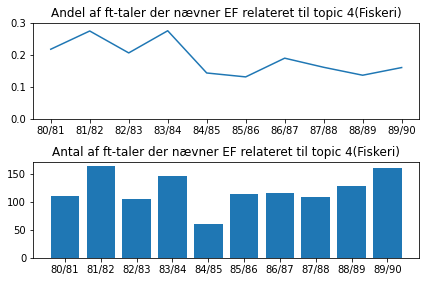

In [68]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 4(Fiskeri)")
ax1.plot(folketingsår, fiskeri_andel)
ax1.set_ylim([0, 0.3])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 4(Fiskeri)")
ax2.bar(folketingsår, antal_taler_1980eren_fiskeri)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_4")

<BarContainer object of 10 artists>

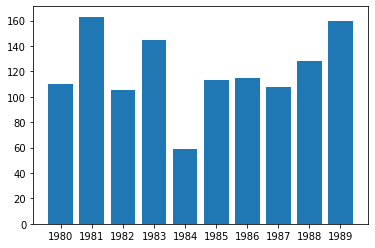

In [534]:
fig, ax = plt.subplots()
ax.bar(år_1980erne, antal_taler_1980eren_fiskeri)

### Grønland 1986/1987

In [442]:
Grønland_taler_høj_1986 = [i for i in topics_fiskeri_høj_sand if Alle_taler_år[i] == "1986"]

In [443]:
len(Grønland_taler_høj_1986)

19

In [447]:
random_tal= randint(0, len(Grønland_taler_høj_1986))
random_index = Grønland_taler_høj_1986[random_tal]
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler_taler[random_index])
print(Alle_taler[random_index])

1986
Regeringen
Fiskeriministeren (Gammelgaard):
 Jeg tillader mig herved for det høje Ting at fremsætte: Forslag til lov om støtte til visse strukturforanstaltninger inden for fiskeriet m.v. (Lovforslag nr. L 200). EFs ministerråd vedtog den 18. december 1986 Det Europæiske Økonomiske Fællesskabs forordning nr. 4028/86 om fællesskabsforanstaltninger til forbedring og tilpasning af fiskeri- og akvakulturstrukturerne. Denne strukturforordning indeholder mulighed for at opnå fællesskabsstøtte til omstrukturering og fornyelse af fiskerflåden, modernisering af fiskerflåden, opdræt, forsøgsfiskeri, fællesforetagender, ophør, midlertidig oplægning, fiskerihavnes faciliteter, markeds- prospektering og specifikke foranstaltninger. Efter forhandling med fiskerierhvervet og med udgangspunkt i den danske fiskerisektors situation og fremtid giver lovforslaget adgang til umiddelbart i Danmark at anvende strukturforordningens støttemuligheder for ophør, modernisering af fiskerflåden, om- struktureri

## Miljø

In [84]:
topics_miljø = []
topics_miljø_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 16:
            topics_miljø.append(index)
            topics_miljø_sand.append(sand)

In [85]:
len(topics_miljø)

935

In [86]:
topic_miljø_høj_sand = [topics_miljø[i] for i in range(len(topics_miljø)) if topics_miljø_sand[i] >= 0.1]
len(topic_miljø_høj_sand)

59

In [87]:
random_tal= randint(0, len(topic_miljø_høj_sand))
random_index = topic_miljø_høj_sand[random_tal]
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler[random_index])

1986
(FP)
 I redegørelsen står der »marginaljorder«, uden at der med et eneste ord er nævnt bonitering. Det er en gammel tradition, at når man snakker om marginaljorder, så bruger vi ordet bonitering. Den er ikke nævnt i denne redegørelse. »Marginal« betyder »på grænsen«, og den borgerlige regering har, siden den kom til i 1982, pålagt det mest liberale erhverv, vi har i Danmark, nemlig landbruget, så mange forordninger, at det snart er på grænsen af, hvad dette erhverv kan bære. Og den samme regering har gennem sin miljøminister over for den øvrige befolkning udlagt landbruget som den store forurener, uden at de påstande har været ordentligt dokumenteret, og det har bragt bønderne på grænsen af det, der kan betegnes som psykisk vold. Og nu har vi så igen en redegørelse, der taler hen over hovedet på bønderne og landmanden, pg som fuldstændig forvirrer og bedrager den ukyndige læser. Hvad mener regeringen eller ministeren med ord som »strategi«? Det er et ord, der leder tanken hen på h

In [88]:
len(Alle_taler)

6636

In [89]:
Miljø_taler_år = [Alle_taler_år[i] for i in topics_miljø]
Miljø_antal_taler_1980eren = []

for år in år_1980erne:
    Miljø_antal_taler_1980eren.append(Miljø_taler_år.count(år))
miljø_andel = [Miljø_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

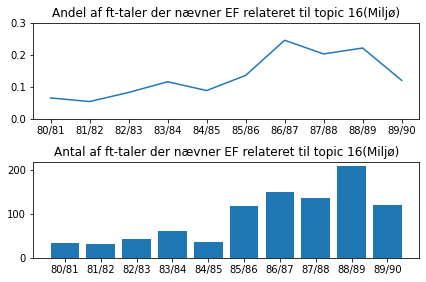

In [108]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 16(Miljø)")
ax1.plot(folketingsår, miljø_andel)
ax1.set_ylim([0, 0.3])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 16(Miljø)")
ax2.bar(folketingsår, Miljø_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_16")

<BarContainer object of 10 artists>

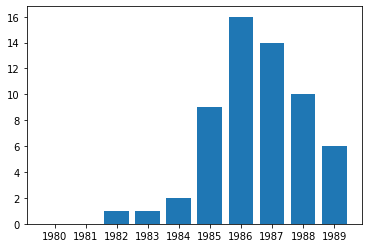

In [91]:
Miljø_taler_år_høj = [Alle_taler_år[i] for i in topic_miljø_høj_sand]
Miljø_antal_taler_1980eren_høj = []

for år in år_1980erne:
    Miljø_antal_taler_1980eren_høj.append(Miljø_taler_år_høj.count(år))
    
fig, ax = plt.subplots()
ax.bar(år_1980erne, Miljø_antal_taler_1980eren_høj)

In [92]:
høj_sandsynlighed_1980 = []
for index in topic_miljø_høj_sand:
    if Alle_taler_år[index] == "1988":
        høj_sandsynlighed_1980.append(index)
len(høj_sandsynlighed_1980)

10

In [93]:
randint(0, len(høj_sandsynlighed_1980))

4

In [94]:
random_tal= randint(0, len(høj_sandsynlighed_1980)-1)
random_index = høj_sandsynlighed_1980[random_tal]
print()
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler[random_index])


1988
Regeringen
 Jeg skal herved tillade mig at fremsætte: Forslag til lov om afgift af visse chlorfluorcar- boner og haloner. (CFC-afgift). (Lovforslag nr. L 98). Der er blandt forskere enighed om, at udslip af de kemiske stoffer, som betegnes chlorfluor- carboner (CFC) og haloner, medfører en nedbrydning af ozonlaget og klimatiske ændringer. Ozonlaget beskytter Jorden mod skadelig ultraviolet stråling fra Solen. Ultraviolet stråling kan medføre biologiske skader på mennesker, dyr og planter. Derfor indgik Danmark sammen med en række andre lande og EF en international aftale i FN-regi i september 1987 - den såkaldte Montrealprotokol. Aftaleparterne forpligter sig ifølge protokollen til at reducere forbruget af CFC over en årrække, således at forbruget af CFC i 1998-99 højst er på 50 pet. af 1986-ni- veauet, og at fastfryse forbruget af haloner. Aftaleparterne forpligter sig endvidere til at begrænse produktionen af disse stoffer. Desuden forpligter parterne sig til at samarbejde for 

## Landbrug

In [95]:
topics_landbrug = []
topics_landbrug_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 15:
            topics_landbrug.append(index)
            topics_landbrug_sand.append(sand)
len(topics_landbrug)

762

In [96]:
topic_landbrug_høj_sand = [topics_landbrug[i] for i in range(len(topics_landbrug)) if topics_landbrug_sand[i] >= 0.1]
len(topic_landbrug_høj_sand)

106

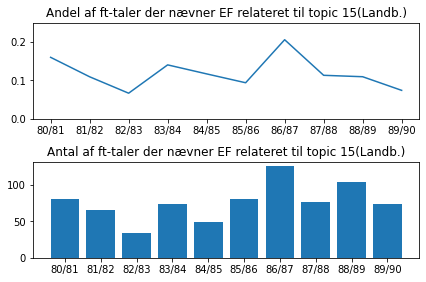

In [97]:
landbrug_taler_år = [Alle_taler_år[i] for i in topics_landbrug]
landbrug_antal_taler_1980eren = []

for år in år_1980erne:
    landbrug_antal_taler_1980eren.append(landbrug_taler_år.count(år))
landbrug_andel = [landbrug_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 15(Landb.)")
ax1.plot(folketingsår, landbrug_andel)
ax1.set_ylim([0, 0.25])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 15(Landb.)")
ax2.bar(folketingsår, landbrug_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_15")
#ax.plot(år_1980erne, landbrug_andel)

### Undersøgelse af 86/87

In [98]:
topic_landbrug_høj_sand_1986 = [i for i in topic_landbrug_høj_sand if Alle_taler_år[i] == "1986"]
topic_landbrug_1986 = [i for i in topics_landbrug if Alle_taler_år[i] == "1986"]
print(len(topic_landbrug_1986))
len(topic_landbrug_høj_sand_1986)

125


10

In [99]:
random_tal= randint(0, len(topic_landbrug_høj_sand_1986)-1)
random_index = topic_landbrug_høj_sand_1986[random_tal]
print(Alle_taler_taler[random_index])
print(Alle_taler_år[random_index])
print(Alle_taler_parti[random_index])
print(Alle_taler[random_index])

Grove (KF) :
1986
(KF)
 »Vil ministeren på det førstkommende rådsmøde for landbrugsministre i EF prøve på at få justeret den grønne krone?« Begrundelse Landbrugets indtjening er faldet meget i den senere tid. Derfor er det nødvendigt med en hurtig justering af den grønne krone, så landbruget hurtigst muligt kan få gavn af opskrivningen af den tyske D-mark. Svar (15/1 87):


### Landbrug og miljø:

In [100]:
Landbrug_og_miljø_1986 = [i for i in topic_landbrug_1986 if i in topics_miljø]
len(Landbrug_og_miljø_1986)

57

In [101]:
Landbrug_og_miljø = [i for i in topics_landbrug if i in topics_miljø]

In [102]:
len(Landbrug_og_miljø)

225

In [103]:
Landbrug_og_miljø_år = [Alle_taler_år[i] for i in Landbrug_og_miljø]
Landbrug_og_miljø_antal_taler_1980eren = []

for år in år_1980erne:
    Landbrug_og_miljø_antal_taler_1980eren.append(Landbrug_og_miljø_år.count(år))
Landbrug_og_miljø_antal_taler_1980eren

[8, 7, 2, 8, 7, 23, 57, 37, 50, 26]

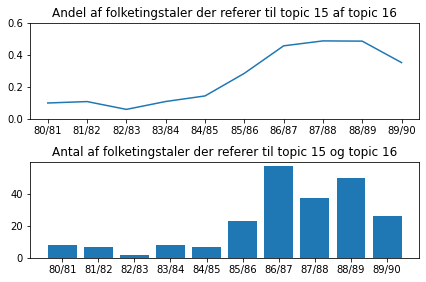

In [104]:
Landbrug_og_miljø_andel = [Landbrug_og_miljø_antal_taler_1980eren[i]/landbrug_antal_taler_1980eren[i] for i in range(10)]
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af folketingstaler der referer til topic 15 af topic 16")
ax1.plot(folketingsår, Landbrug_og_miljø_andel)
ax1.set_ylim([0, 0.60])
ax2.set_title("Antal af folketingstaler der referer til topic 15 og topic 16")
ax2.bar(folketingsår, Landbrug_og_miljø_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_referer_til_topic_15_af_topic_16_med_total")
ax.plot(år_1980erne, landbrug_andel)

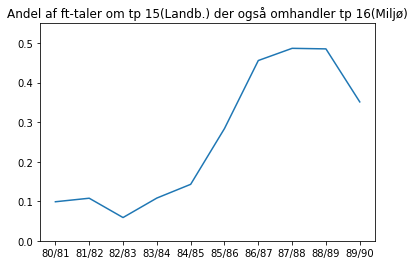

In [106]:
fig, ax = plt.subplots()
ax.set_title("Andel af ft-taler om tp 15(Landb.) der også omhandler tp 16(Miljø)")
ax.plot(folketingsår, Landbrug_og_miljø_andel)
ax.set_ylim([0, 0.55])
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_referer_til_topic_15_af_topic_16")

### Arbejdsmiljø

In [110]:
topics_arbejds_miljø = []
topics_arbejds_miljø_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 18:
            topics_arbejds_miljø.append(index)
            topics_arbejds_miljø_sand.append(sand)

In [111]:
len(topics_arbejds_miljø)

702

In [112]:
arbejds_miljø_taler_år = [Alle_taler_år[i] for i in topics_arbejds_miljø]
arbejds_miljø_taler_1980eren = []

for år in år_1980erne:
    arbejds_miljø_taler_1980eren.append(arbejds_miljø_taler_år.count(år))
arbejds_miljø_andel = [arbejds_miljø_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

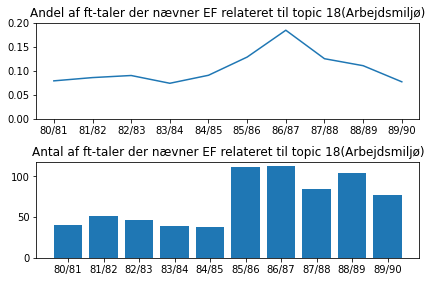

In [113]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 18(Arbejdsmiljø)")
ax1.plot(folketingsår, arbejds_miljø_andel)
ax1.set_ylim([0, 0.2])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 18(Arbejdsmiljø)")
ax2.bar(folketingsår, arbejds_miljø_taler_1980eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_18")

### Undersøgelse af stof i arbejdsmiljø

In [596]:
topics_arbejds_miljø_sand.index(max(topics_arbejds_miljø_sand))

293

In [597]:
topics_arbejds_miljø_sand_til_sort = [sand for sand in topics_arbejds_miljø_sand]

In [598]:
topics_arbejds_miljø_sand_til_sort.sort(reverse = True)

In [608]:
topics_arbejds_miljø_sand.index(topics_arbejds_miljø_sand_til_sort[4])

476

In [609]:
topics_arbejds_miljø[476]

4385

In [610]:
print(Alle_taler_taler[4385])
print(Alle_taler_år[4385])
Alle_taler[4385]

Af Dorte Bennedsen (S) m.fl.
1987


" (Fremsat 29/1 88). Forslaget sattes til forhandling. Forhandling Miljøministeren (Chr. Christensen): Vi har i Folketinget tidligere drøftet spørgsmålet om advarselsmærkning af de stoffer, der anses eller mistænkes for at være kræftfremkaldende. Jeg er fortsat enig i forslagets intentioner om at beskytte befolkningen og arbejdstagerne imod kræftfremkaldende stoffer, men jeg har dog visse bemærkninger til indholdet i forslaget, og dem vil jeg vende tilbage til senere. Indledningsvis vil jeg nævne, at jeg synes, at regeringen er nået et godt stykke på vej med 6735 17/2 88: l. beh. af f. t. beslutn. vedr. kræftfremkaldende stoffer 6736 [Miljøministeren] hensyn til dette forslag. I alt skal knap 80 stoffer ifølge listen over farlige stoffer mærkes med en af de to advarselssætninger, som ifølge et EF- direktiv benyttes til advarselsmærkning af kræftfremkaldende stoffer. Det drejer sig om følgende to sætninger: den såkaldte R 45, »kan fremkalde kræft«, og R 40, »mulig fare fot uhelbredelig 

## Afgift

In [115]:
topics_afgift = []
topics_afgift_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 9:
            topics_afgift.append(index)
            topics_afgift_sand.append(sand)
len(topics_afgift)

870

In [116]:
afgift_høj_sand = [topics_afgift[i] for i in range(len(topics_afgift)) if topics_afgift_sand[i] >= 0.05]

In [117]:
len(afgift_høj_sand)

173

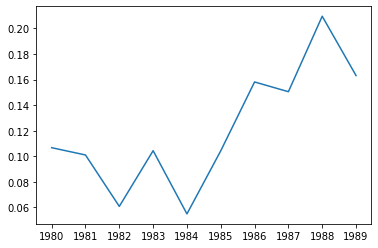

In [118]:
topics_afgift_år = [Alle_taler_år[i] for i in topics_afgift]
afgift_antal_taler_1980eren = []

for år in år_1980erne:
    afgift_antal_taler_1980eren.append(topics_afgift_år.count(år))
afgift_andel = [afgift_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]
fig, ax = plt.subplots()
ax.plot(år_1980erne, afgift_andel)

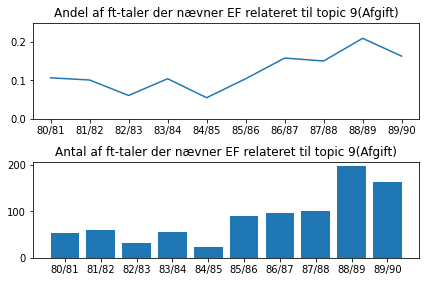

In [119]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 9(Afgift)")
ax1.plot(folketingsår, afgift_andel)
ax1.set_ylim([0, 0.25])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 9(Afgift)")
ax2.bar(folketingsår, afgift_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_9")

### Topic 12 om ef:

In [122]:
topics_ef_12 = []
topics_ef_12_sand = []
for index in range(len(data_lemmatized)):
    bow = gensim_dictionary.doc2bow(data_lemmatized[index])
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 12:
            topics_ef_12.append(index)
            topics_ef_12_sand.append(sand)
len(topics_afgift)

870

In [123]:
topics_ef_12_år = [Alle_taler_år[i] for i in topics_ef_12]
ef_12_antal_taler_1980eren = []

for år in år_1980erne:
    ef_12_antal_taler_1980eren.append(topics_ef_12_år.count(år))
ef_12_andel = [ef_12_antal_taler_1980eren[i]/antal_taler_år[i] for i in range(10)]

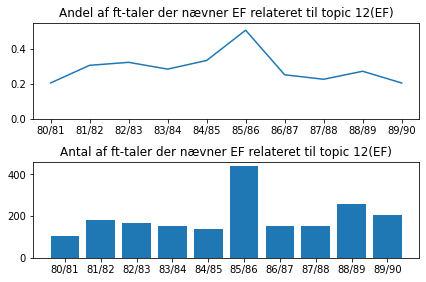

In [124]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_title("Andel af ft-taler der nævner EF relateret til topic 12(EF)")
ax1.plot(folketingsår, ef_12_andel)
ax1.set_ylim([0, 0.55])
ax2.set_title("Antal af ft-taler der nævner EF relateret til topic 12(EF)")
ax2.bar(folketingsår, ef_12_antal_taler_1980eren)
fig.tight_layout(pad=1.0)
fig.savefig("plots/1980_erne/Andel_af_folketingstaler_der_nævner_EF relateret_til_topic_12")

In [529]:
#undersøgelse af EF_pakken

In [531]:
ef_pakken = []
for tale in data_lemmatized:
    if "ef-pakken" in tale:
        ef_pakken.append(tale)
len(ef_pakken)

260

In [533]:
antal_ef_pakken_topic_12 = 0
for tale in ef_pakken:
    bow = gensim_dictionary.doc2bow(tale)
    eu_tale_topic_distribution = lda_model.get_document_topics(bow)
    for topic, sand in eu_tale_topic_distribution:
        if topic == 12:
            antal_ef_pakken_topic_12 += 1
antal_ef_pakken_topic_12

236

### Undersøgelse af slutningen af 1980'ernes ef debat

### Økonomi i danske EF-debatter:

# EF-pakken

In [538]:
Ef_pakken_ord = ["ef-pakken", "fællesakt"]
ef_pakken_taler = {}
for år in Folketingsår_opdelt_per_taler_80erne:
    #start = time()
    eu_tale_år = []
    eu_parti_år = []
    eu_taler_år = []
    for index in range(len(Folketingsår_opdelt_per_taler_80erne[år][0])):
        tale = Folketingsår_opdelt_per_taler_80erne[år][0][index]
        for ord_ in Ef_pakken_ord:
            if len(re.findall(ord_, tale.lower())) > 0:
                eu_tale_år.append(tale)
                eu_parti_år.append(Folketingsår_opdelt_per_taler_80erne[år][1][index])
                eu_taler_år.append(Folketingsår_opdelt_per_taler_80erne[år][2][index])
                break
    ef_pakken_taler[år] = []
    ef_pakken_taler[år].append(eu_tale_år)
    ef_pakken_taler[år].append(eu_parti_år)
    ef_pakken_taler[år].append(eu_taler_år)
    #slut = time()
    #print(slut-start) til at time loopsne

In [539]:
for år in ef_pakken_taler:
    print(f"{år}: {len(ef_pakken_taler[år][0])}")

1980: 1
1981: 2
1982: 0
1983: 1
1984: 0
1985: 182
1986: 40
1987: 30
1988: 41
1989: 12


In [540]:
tekster_klar_ef_pakken = []
for år in ef_pakken_taler:
    #allowed_postags=['NOUN', 'ADJ', 'VERB']
    start = time()
    for tekst in ef_pakken_taler[år][0]:
        tale_spacy = nlpd(tekst.lower())
        #tokens = [str(token.lemma_).lower() for token in tale_spacy]
        tokens = [token for token in tale_spacy]
        tokens_uden_tegn = [str(token) for token in tokens if token.pos_ not in typer_spacy]
        #tokens_uden_stopord = [token for token in tokens_uden_tegn if token not in stopord]
        tekster_klar_ef_pakken.append(tokens_uden_tegn)
    end = time()
    print(end-start)

1.1287500858306885
8.359290838241577
2.1457672119140625e-06
0.7266340255737305
3.0994415283203125e-06
19.866804122924805
9.510817050933838
8.99788498878479
8.981775045394897
3.3682522773742676


In [541]:
processed_data_ef_pakken = []
for tekst in tekster_klar_ef_pakken:
    str_tekst = [str(token) for token in tekst]
    processed_data_ef_pakken.append(str_tekst)

In [542]:
bigram_ef_pakken = gensim.models.Phrases(processed_data_ef_pakken, min_count=5, threshold=100)

trigram_ef_pakken = gensim.models.Phrases(bigram_ef_pakken[processed_data_ef_pakken], threshold=100)

bigram_mod_ef_pakken = gensim.models.phrases.Phraser(bigram_ef_pakken)

trigram_mod_ef_pakken = gensim.models.phrases.Phraser(trigram_ef_pakken)

In [543]:
data_wo_stopwords_ef_pakken = remove_stopwords(processed_data_ef_pakken)

data_bigrams_ef_pakken = create_bigrams(data_wo_stopwords_ef_pakken)

data_lemmatized_ef_pakken = lemmatize(data_bigrams_ef_pakken, allowed_postags=['NOUN', 'ADJ', 'VERB', 'PROPN', 'ADV'])

stopwords_removed_2_ef_pakken= remove_stopwords(data_lemmatized_ef_pakken) #Jeg prøver at sortere stopord fra igen

data_lemmatized_ef_pakken = stopwords_removed_2_ef_pakken

16.64385414123535


In [544]:
texts_ef_pakken = [text for text in data_lemmatized_ef_pakken]

shuffle(texts_ef_pakken)

gensim_dictionary_ef_pakken = corpora.Dictionary(texts_ef_pakken)

gensim_corpus_ef_pakken = [gensim_dictionary_ef_pakken.doc2bow(text) for text in texts_ef_pakken]

In [545]:
def compute_coherence_values_ef_pakken(k):
    lda_model_ef_pakken = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_ef_pakken,
                                            id2word=gensim_dictionary_ef_pakken,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")
    
    coherence_model_lda = CoherenceModel(model=lda_model_ef_pakken, texts=data_lemmatized_ef_pakken, dictionary=gensim_dictionary_ef_pakken, coherence='c_v')
    return coherence_model_lda.get_coherence()

In [546]:
# Topics range
min_topics = 5
max_topics = 20
step_size = 1
topics_range = range(min_topics, max_topics, step_size)

#empty dataframe
model_results_ef_pakken = {'Topics': [],
                 'Coherence': []
                }

# iterate through number of topics
for k in topics_range:
    print(k)
    # get the coherence score for the given topics
    cv = compute_coherence_values_ef_pakken(k=k)
    # Save the model results
    model_results_ef_pakken['Topics'].append(k)
    model_results_ef_pakken['Coherence'].append(cv)

5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Text(0.5, 1.0, 'Simple model_ef_pakken')

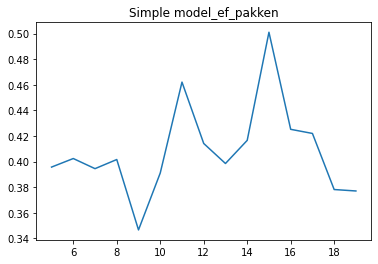

In [547]:
fig, ax = plt.subplots()
ax.plot(model_results_ef_pakken["Topics"], model_results_ef_pakken['Coherence'])
ax.set_title("Simple model_ef_pakken")

In [548]:
lda_model_ef_pakken = gensim.models.ldamodel.LdaModel(corpus=gensim_corpus_ef_pakken,
                                           id2word=gensim_dictionary_ef_pakken,
                                           num_topics=15, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto")

In [549]:
pprint(lda_model_ef_pakken.print_topics())

[(0,
  '0.026*"hr." + 0.020*"danmark" + 0.014*"folketing" + 0.014*"debat" + '
  '0.013*"stemme" + 0.013*"folkeafstemning" + 0.013*"udenrigsminister" + '
  '0.013*"ef-pakken" + 0.012*"gå" + 0.010*"socialdemokrati"'),
 (1,
  '0.005*"bevarelse" + 0.004*"dorte_bennedsen" + 0.001*"telekommunikation" + '
  '0.001*"miljøforslag" + 0.001*"tilgå" + 0.001*"fredningsmyndighed" + '
  '0.001*"fredningssag" + 0.001*"venstreminister" + 0.001*"granske" + '
  '0.001*"udbudspligt"'),
 (2,
  '0.019*"veto" + 0.017*"opklare" + 0.008*"knud_lind" + 0.008*"bilpark" + '
  '0.005*"forretning" + 0.005*"direktivforslag" + 0.005*"ef-traktaten" + '
  '0.004*"afgiftsniveau" + 0.004*"katalysator" + 0.004*"fritage"'),
 (3,
  '0.021*"marked" + 0.021*"regering" + 0.018*"samarbejde" + 0.014*"arbejde" + '
  '0.013*"medlemsland" + 0.011*"danmark" + 0.010*"forslag" + 0.010*"land" + '
  '0.009*"udvikling" + 0.008*"erhvervsliv"'),
 (4,
  '0.059*"lov" + 0.041*"ændring" + 0.031*"lovforslag" + 0.019*"forslag" + '
  '0.015*"frems

## Undersøgelse:

In [439]:
gensim_corpus_ikke_random[0]

[(0, 1),
 (15, 4),
 (25, 1),
 (35, 1),
 (40, 1),
 (46, 4),
 (59, 3),
 (61, 2),
 (65, 2),
 (85, 1),
 (97, 1),
 (110, 4),
 (114, 1),
 (117, 1),
 (118, 1),
 (134, 1),
 (135, 2),
 (152, 1),
 (169, 1),
 (171, 1),
 (173, 1),
 (186, 1),
 (188, 1),
 (197, 1),
 (200, 1),
 (202, 1),
 (239, 1),
 (245, 5),
 (255, 3),
 (294, 2),
 (300, 1),
 (312, 1),
 (336, 1),
 (338, 1),
 (346, 2),
 (350, 1),
 (354, 1),
 (358, 1),
 (364, 1),
 (369, 2),
 (376, 1),
 (381, 1),
 (386, 2),
 (400, 1),
 (421, 1),
 (426, 2),
 (436, 1),
 (466, 4),
 (487, 2),
 (492, 1),
 (495, 1),
 (538, 1),
 (545, 1),
 (551, 1),
 (553, 1),
 (574, 5),
 (575, 1),
 (580, 1),
 (582, 1),
 (637, 1),
 (642, 1),
 (673, 1),
 (675, 2),
 (686, 1),
 (687, 1),
 (693, 1),
 (696, 1),
 (700, 1),
 (717, 1),
 (718, 1),
 (726, 1),
 (729, 1),
 (744, 2),
 (754, 1),
 (805, 2),
 (825, 1),
 (881, 1),
 (940, 3),
 (977, 1),
 (1042, 3),
 (1089, 1),
 (1135, 5),
 (1170, 1),
 (1222, 1),
 (1230, 1),
 (1237, 1),
 (1239, 1),
 (1309, 1),
 (1330, 1),
 (1385, 1),
 (1397, 1),

In [442]:
list_[34430]

'apotekerlovforslaget'